# Affinity of ancient Europeans to present-day populations

In [1]:
library(here)
library(tidyverse)
library(parallel)
library(future)
library(forcats)
library(ggrepel)

library(admixr)
library(bdkn)

plan(multicore)

source(here("code/utils.R"))

here() starts at /mnt/expressions/mp/nea-over-time
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%


Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
samples <- load_samples() %>%
    mutate(name = case_when(name == "new_UstIshim" ~ "UstIshim",
                            name == "new_Loschbour" ~ "Loschbour",
                            TRUE ~ name))

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [3]:
EIGENSTRAT_DIR <- here("data/eigenstrat/bigyri_ho/")

EIGENSTRAT_PREFIX <- paste0(EIGENSTRAT_DIR, "UPA_all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_all.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "all.transitions.snp")

In [4]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

In [5]:
read_snp(SNP_FILE) %>%
    keep_transitions %>%
    write_tsv(BADSNP_FILE, col_names=FALSE)

In [6]:
plot_z <- function(df, z_cut=3, ylim=c(-23, 23), title=NULL) {
    print(ggplot(mutate(df, Y=paste("Y =", Y)), aes(age, Zscore)) +
        geom_point(aes(color=abs(Zscore) > z_cut), size=3, alpha=1/2) +
        geom_hline(yintercept=c(z_cut, -z_cut), linetype=2) +
        geom_hline(yintercept=0, linetype=2, color="red") +
        xlim(40000, 0) + coord_cartesian(y=ylim) +
        ggtitle(title) + xlab("years before present") +
        theme(legend.position="none"))
}

plot_d <- function(df, title, ylim=c(-0.1, 0.05)) {
    print(ggplot(mutate(df, Y=paste("Y =", Y)), aes(age, D)) +
        geom_point(aes(color=abs(Zscore) > 3), size=3, alpha=1/2) +
        facet_wrap(~Y, ncol=4) +
        geom_hline(yintercept=0, linetype=3) +
        xlim(40000, 0) + coord_cartesian(ylim=ylim) +
        ggtitle(title) + xlab("years before present") +
        theme(legend.position="bottom"))
}

In [7]:
near_east <- c("BedouinB", "Yemenite_Jew", "Palestinian", "Iraqi_Jew", "Jordanian",
               "Druze", "Iranian", "Samaritan")

## Ust-Ishim with Chimp as an outgroup

In [8]:
present_day_Y <- list(
    "NearEast" = near_east,
    "EastAsia" = filter(samples, pop == "EastAsia")$name,
    "SouthAsia"= filter(samples, pop == "SouthAsia")$name,
    "Oceania" = filter(samples, pop == "Oceania")$name,
    "WestAfrica" = c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
    "CentralAfrica" = "Mbuti",
    "EastAfrica" = c("Dinka", "BantuKenya", "Masai", "Somali", "Luhya", "Luo"),
    "NorthAfrica" = c("Saharawi", "Mozabite")
)
merge_pops(file = IND_FILE, modified_file = paste0(IND_FILE, ".SGDP_affinity"), present_day_Y)

ancient_X <- filter(samples, pop == "EMH", name != "UstIshim")$name
modern_X <- filter(samples, pop == "WestEurasia", name %notin% near_east)$name

In [9]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats_chimp_ui_list <- mclapply(names(present_day_Y), function(pop) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W="UstIshim", X=ancient_X, Y=pop, Z="Chimp",
                       prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity"))

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W="UstIshim", X=modern_X, Y=pop, Z="Chimp",
                      prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity"))
    
    bind_rows(ancient, modern)
}, mc.cores=length(present_day_Y))

In [10]:
# join Dstat results for ancient and present-day humans
affinity_dstats_chimp_ui <- bind_rows(affinity_dstats_chimp_ui_list) %>%
    inner_join(samples, by=c("X"="name"))

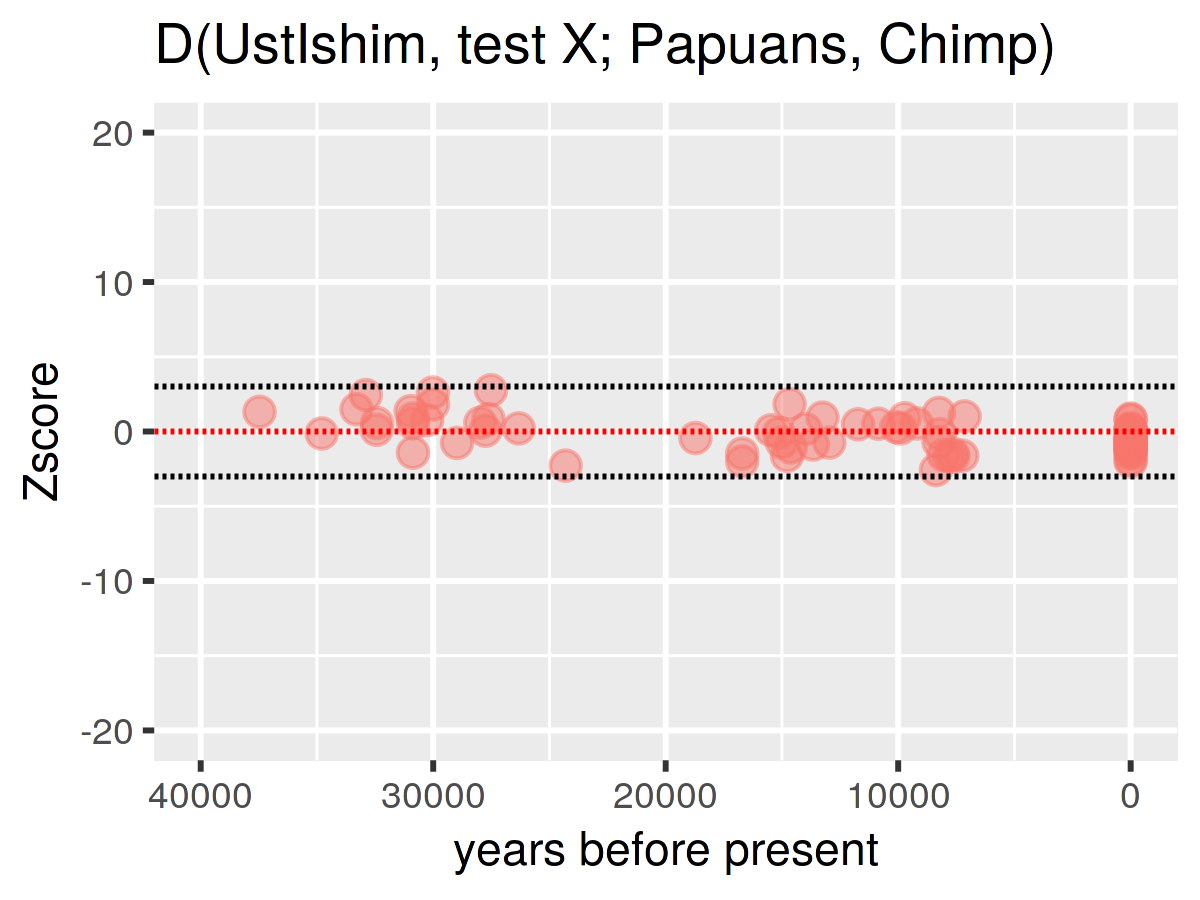

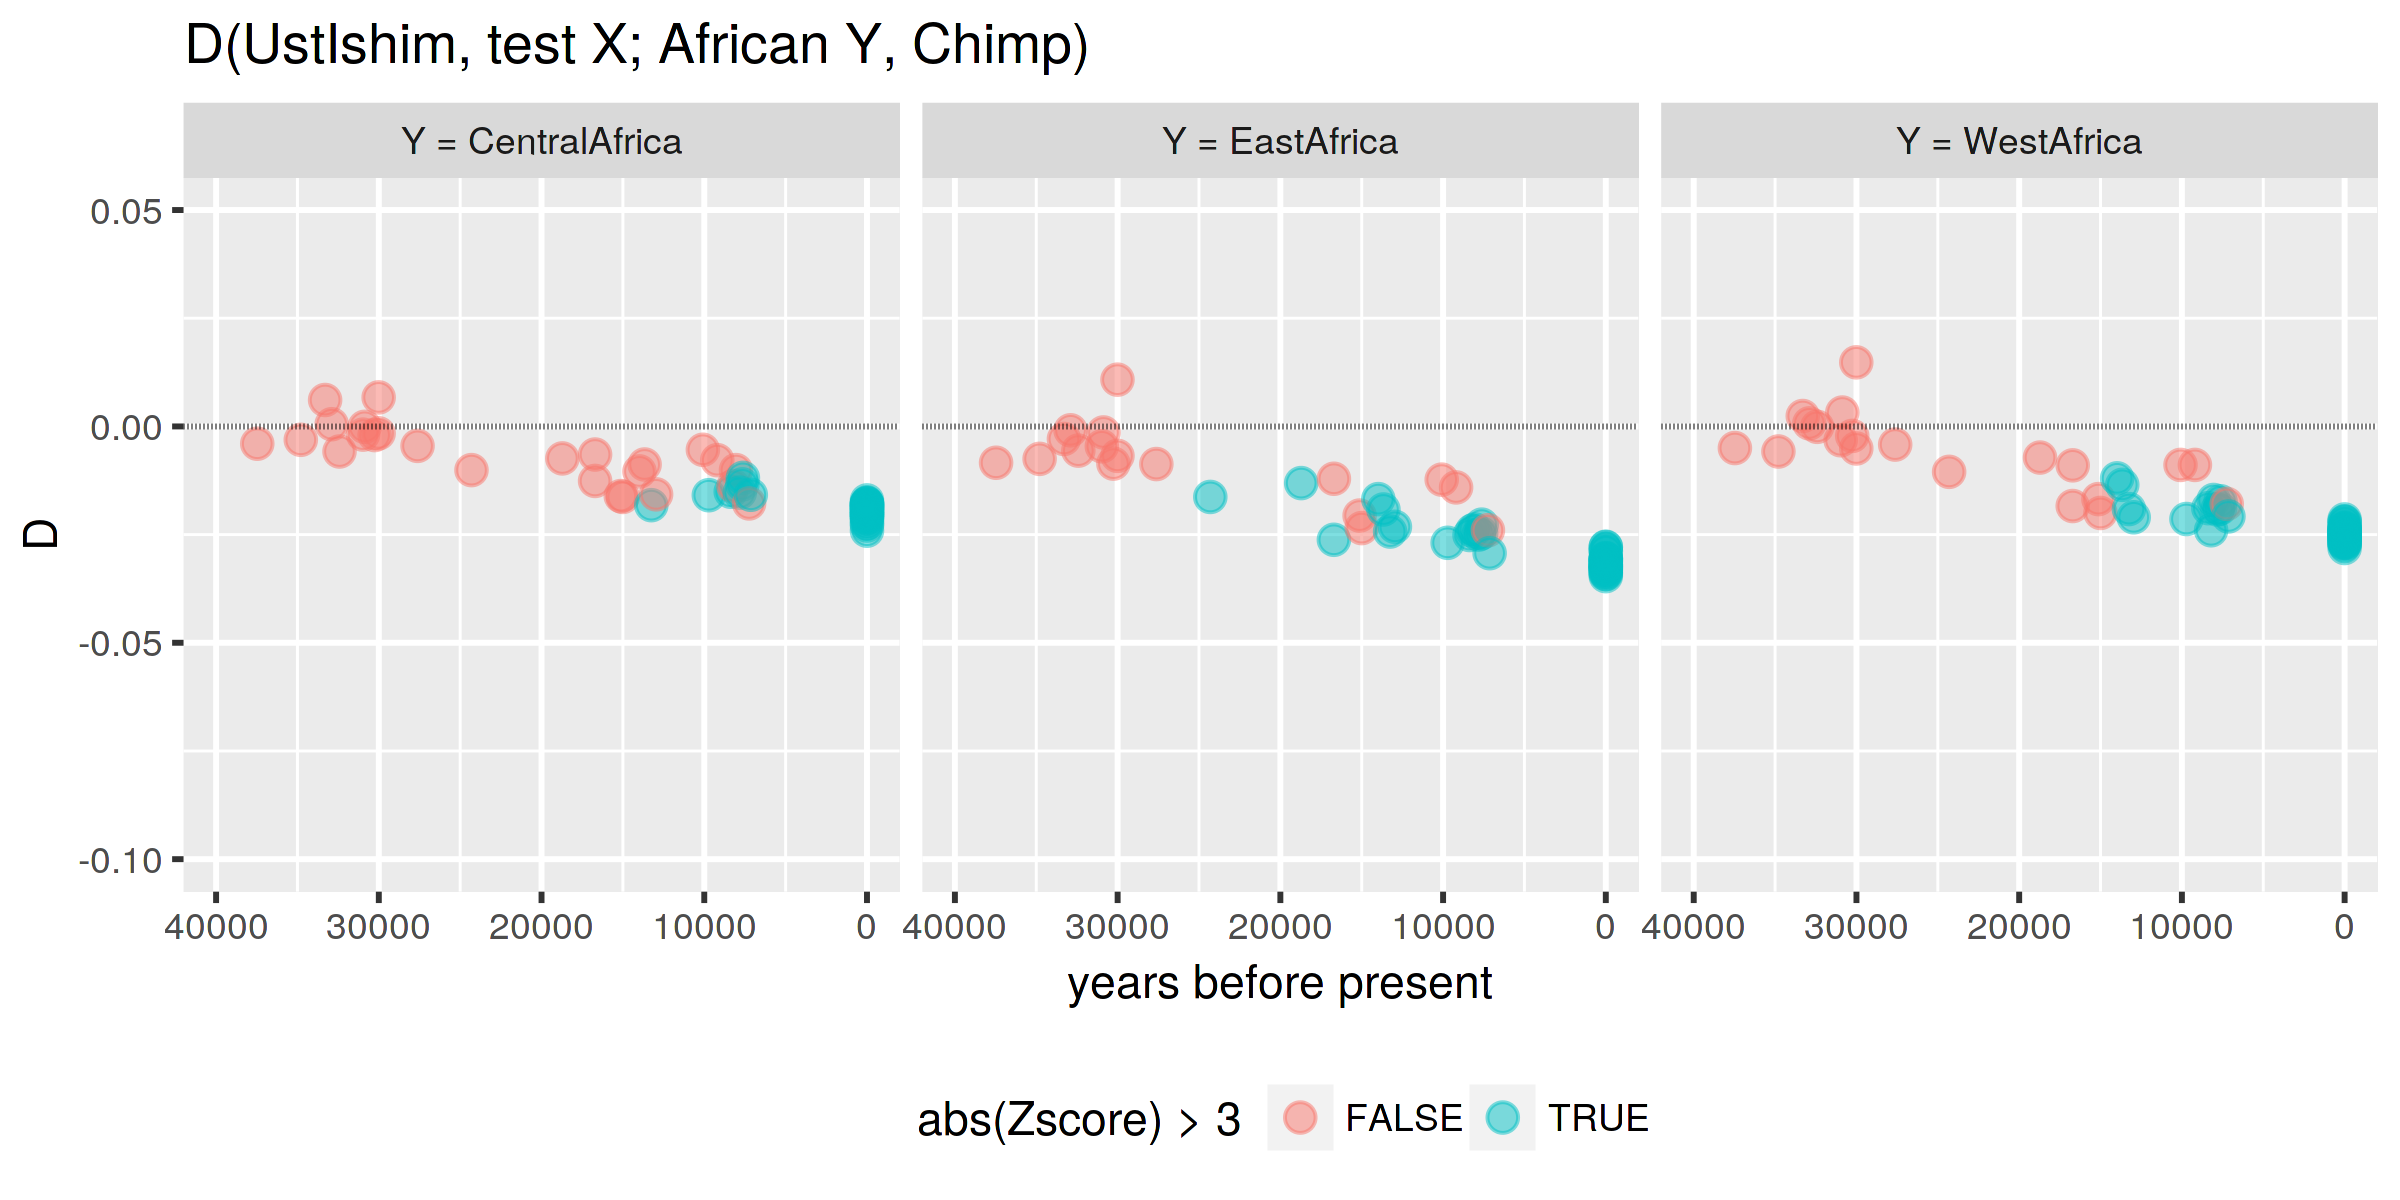

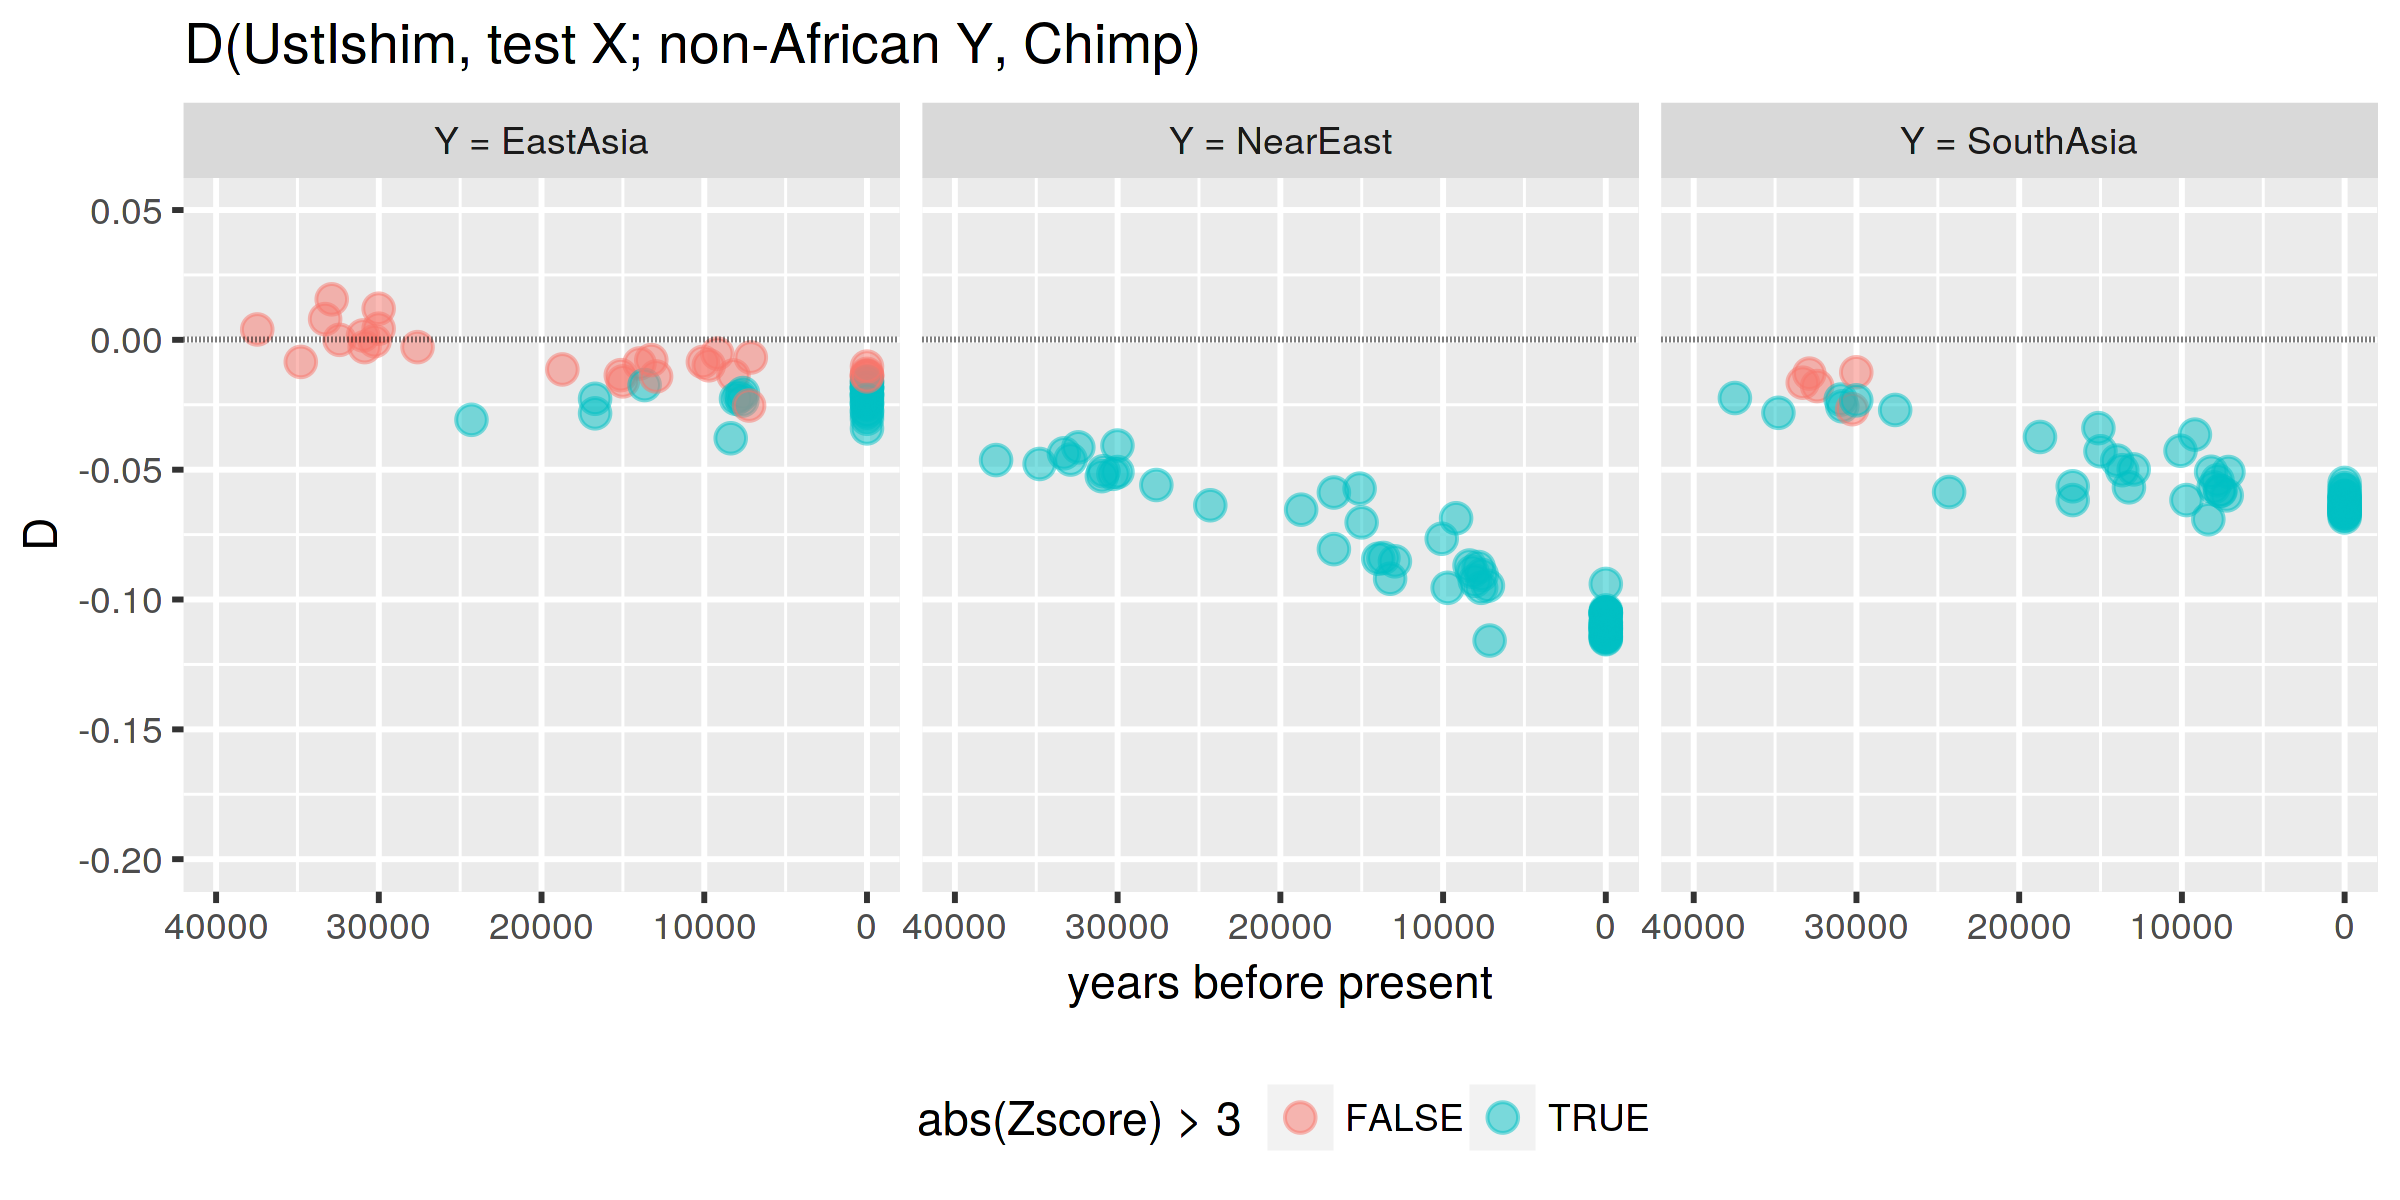

In [11]:
set_dim(4, 3, 300)
filter(affinity_dstats_chimp_ui, Y == "Oceania") %>% plot_z(ylim=c(-20, 20), title="D(UstIshim, test X; Papuans, Chimp)")

set_dim(8, 4, 300)
filter(affinity_dstats_chimp_ui, str_detect(Y, "Africa"), Y != "NorthAfrica") %>% 
filter(n_snps >= 50000) %>% plot_d(title="D(UstIshim, test X; African Y, Chimp)")

set_dim(8, 4, 300)
filter(affinity_dstats_chimp_ui, Y %in% c("EastAsia", "SouthAsia", "NearEast")) %>% 
filter(n_snps >= 50000) %>% plot_d(title="D(UstIshim, test X; non-African Y, Chimp)", ylim=c(-0.2, 0.05))

In [12]:
saveRDS(affinity_dstats_chimp_ui, here("data/rds/sgdp_affinities_ui_chimp.rds"))

## Ust-Ishim vs 3 individual Africans

In [13]:
present_day_Y <- list(
    "Oceania"=filter(samples, pop == "Oceania")$name
)
merge_pops(file=IND_FILE, modified_file=paste0(IND_FILE, ".SGDP_affinity_single_Africans"), present_day_Y)

ancient_X <- filter(samples, pop == "EMH", name != "UstIshim")$name
modern_X <- filter(samples, pop == "WestEurasia", name %notin% near_east)$name

In [14]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats_afr_ui_list <- mclapply(c("Oceania", "Dinka", "Yoruba", "Mbuti"), function(pop) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W="UstIshim", X=ancient_X, Y=pop, Z="Chimp",
                       prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_single_Africans"))

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W="UstIshim", X=modern_X, Y=pop, Z="Chimp",
                      prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_single_Africans"))
    
    bind_rows(ancient, modern)
}, mc.cores=length(present_day_Y))

In [15]:
# join Dstat results for ancient and present-day humans
affinity_dstats_afr_ui <- bind_rows(affinity_dstats_afr_ui_list) %>%
    inner_join(samples, by=c("X"="name"))

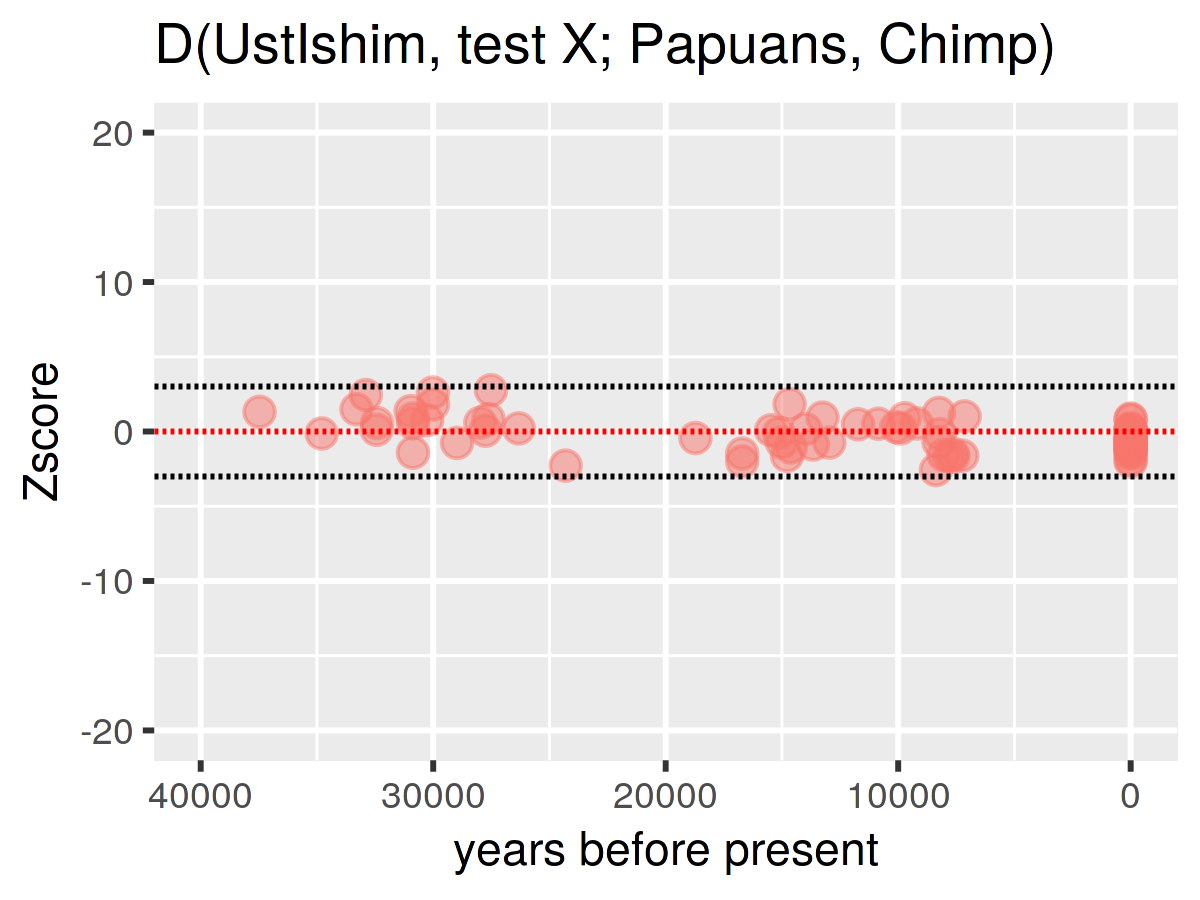

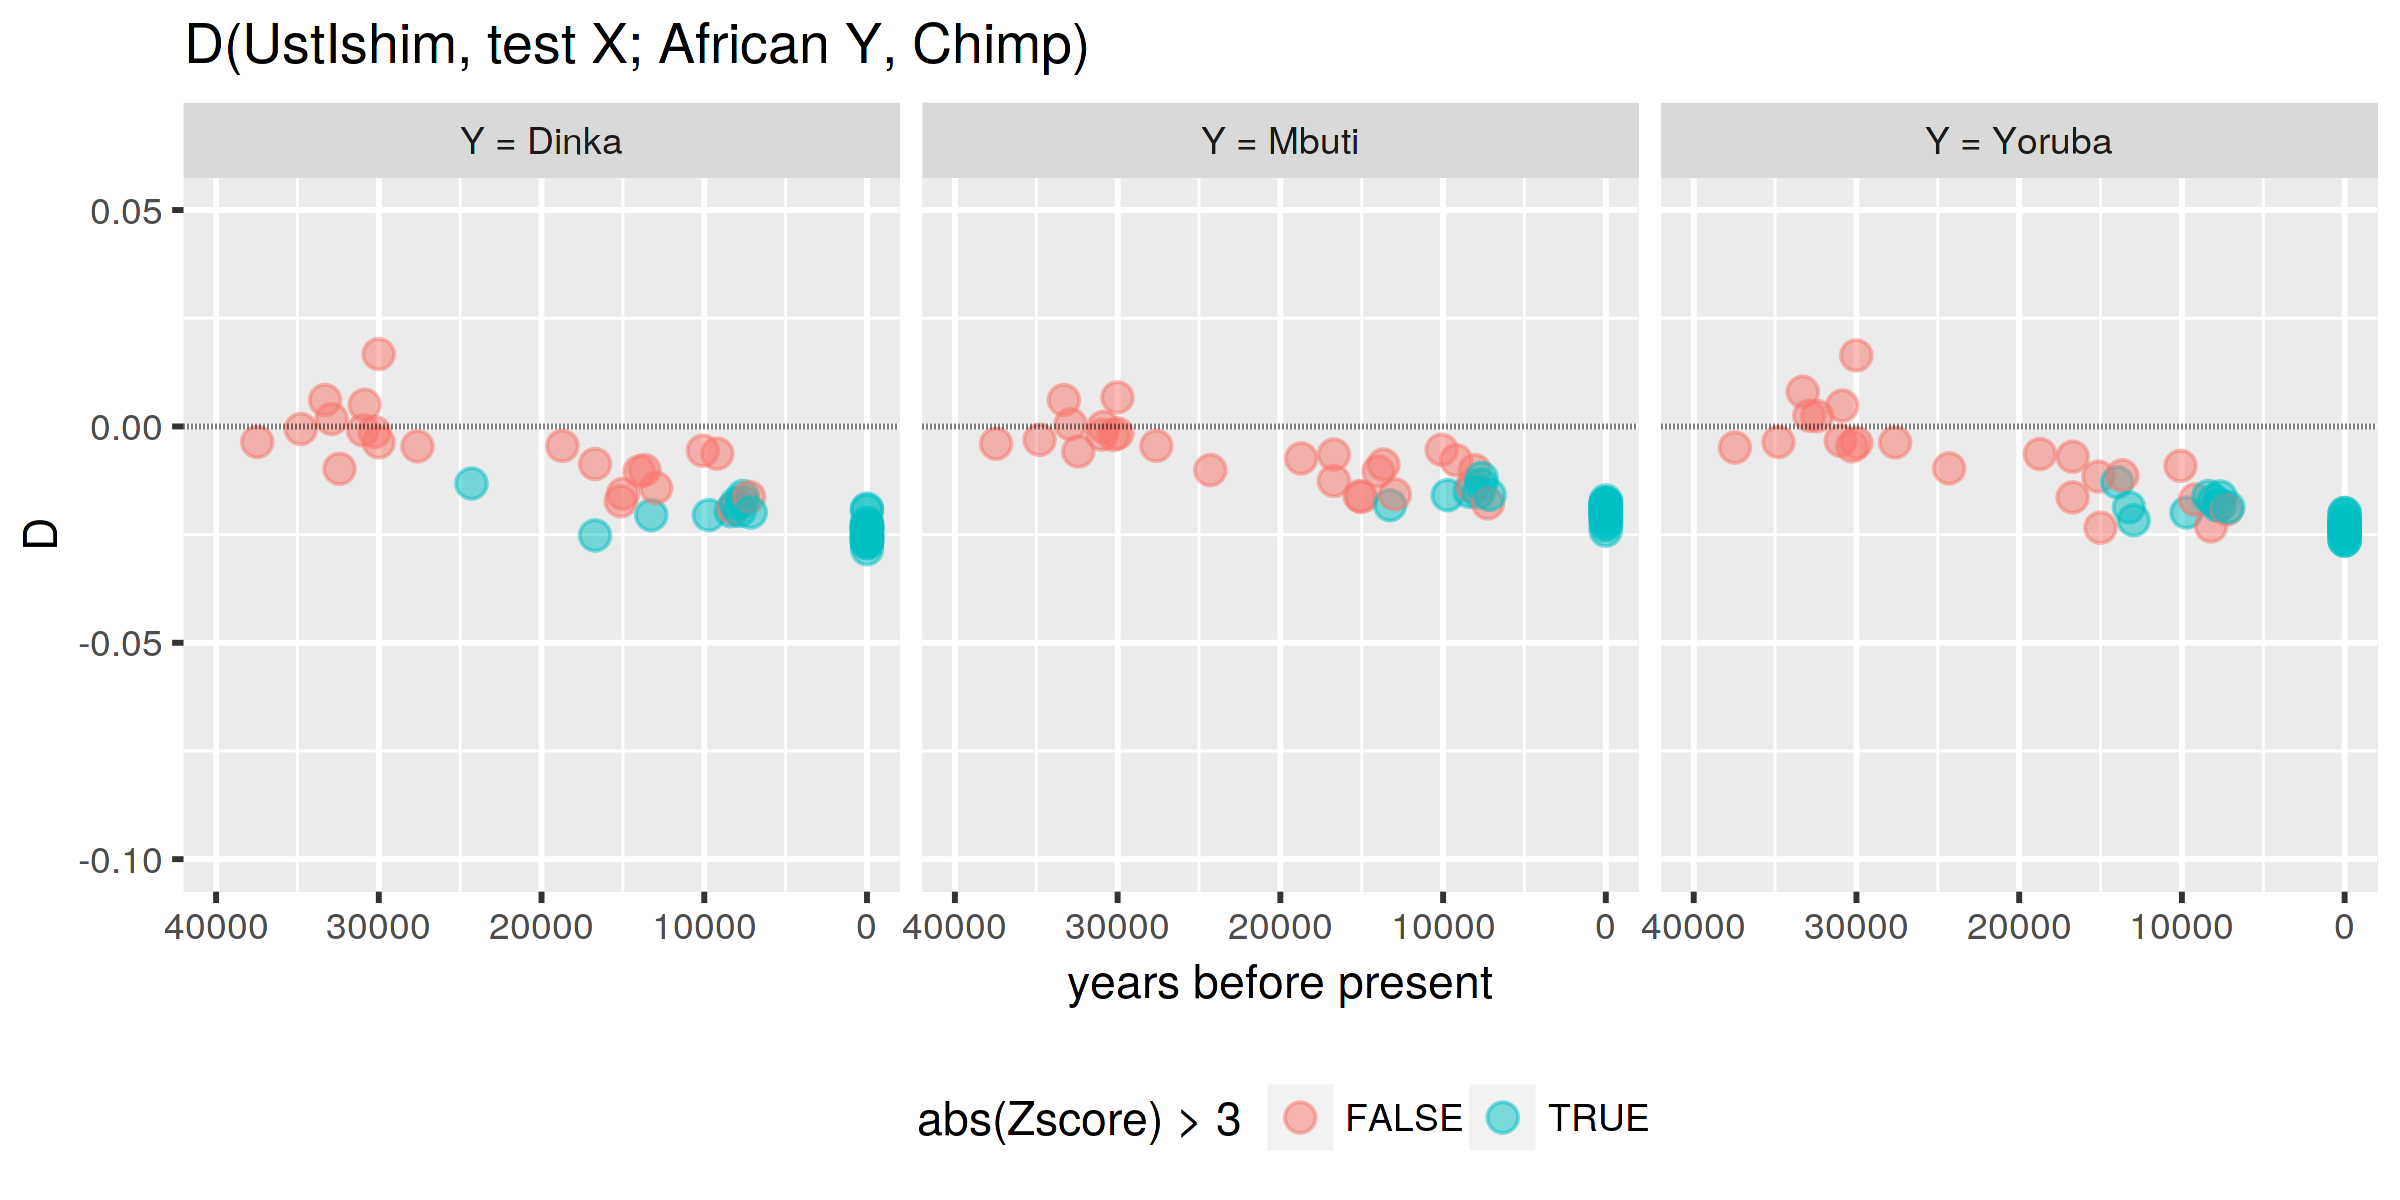

In [16]:
set_dim(4, 3, 300)
filter(affinity_dstats_afr_ui, Y == "Oceania") %>%
    plot_z(ylim=c(-20, 20), title="D(UstIshim, test X; Papuans, Chimp)")

set_dim(8, 4, 300)
filter(affinity_dstats_afr_ui, Y %in% c("Mbuti", "Dinka", "Yoruba")) %>% 
filter(n_snps >= 50000) %>% plot_d(title="D(UstIshim, test X; African Y, Chimp)")

In [17]:
saveRDS(affinity_dstats_afr_ui, here("data/rds/african_affinities_ui_chimp.rds"))

## Basal Eurasian ancestry analysis

In [19]:
zcut <- 3
snpcut <- 500000

In [20]:
X <- c("Han", "Kostenki14")
ancient_eur <- filter(samples, pop == "EMH", name != "UstIshim")$name %>% str_replace("new_", "")
modern_eur <- filter(samples, pop == "WestEurasia")$name

### f4(WestEur, East Asian or early hunter gatherer; Ust-Ishim, Chimp)

In [21]:
ancient_f4 %<-% qpDstat(W=ancient_eur, X=X, Y="UstIshim", Z="Chimp", prefix=EIGENSTRAT_PREFIX, f4mode = TRUE)
modern_f4  %<-% qpDstat(W=modern_eur, X=X, Y="UstIshim", Z="Chimp", prefix=EIGENSTRAT_PREFIX, f4mode = TRUE)

In [22]:
basal_eur <-
    inner_join(bind_rows(ancient_f4, modern_f4), samples, by = c("W"="name")) %>%
    inner_join(snp_counts_f4, by = c("W"="name"))

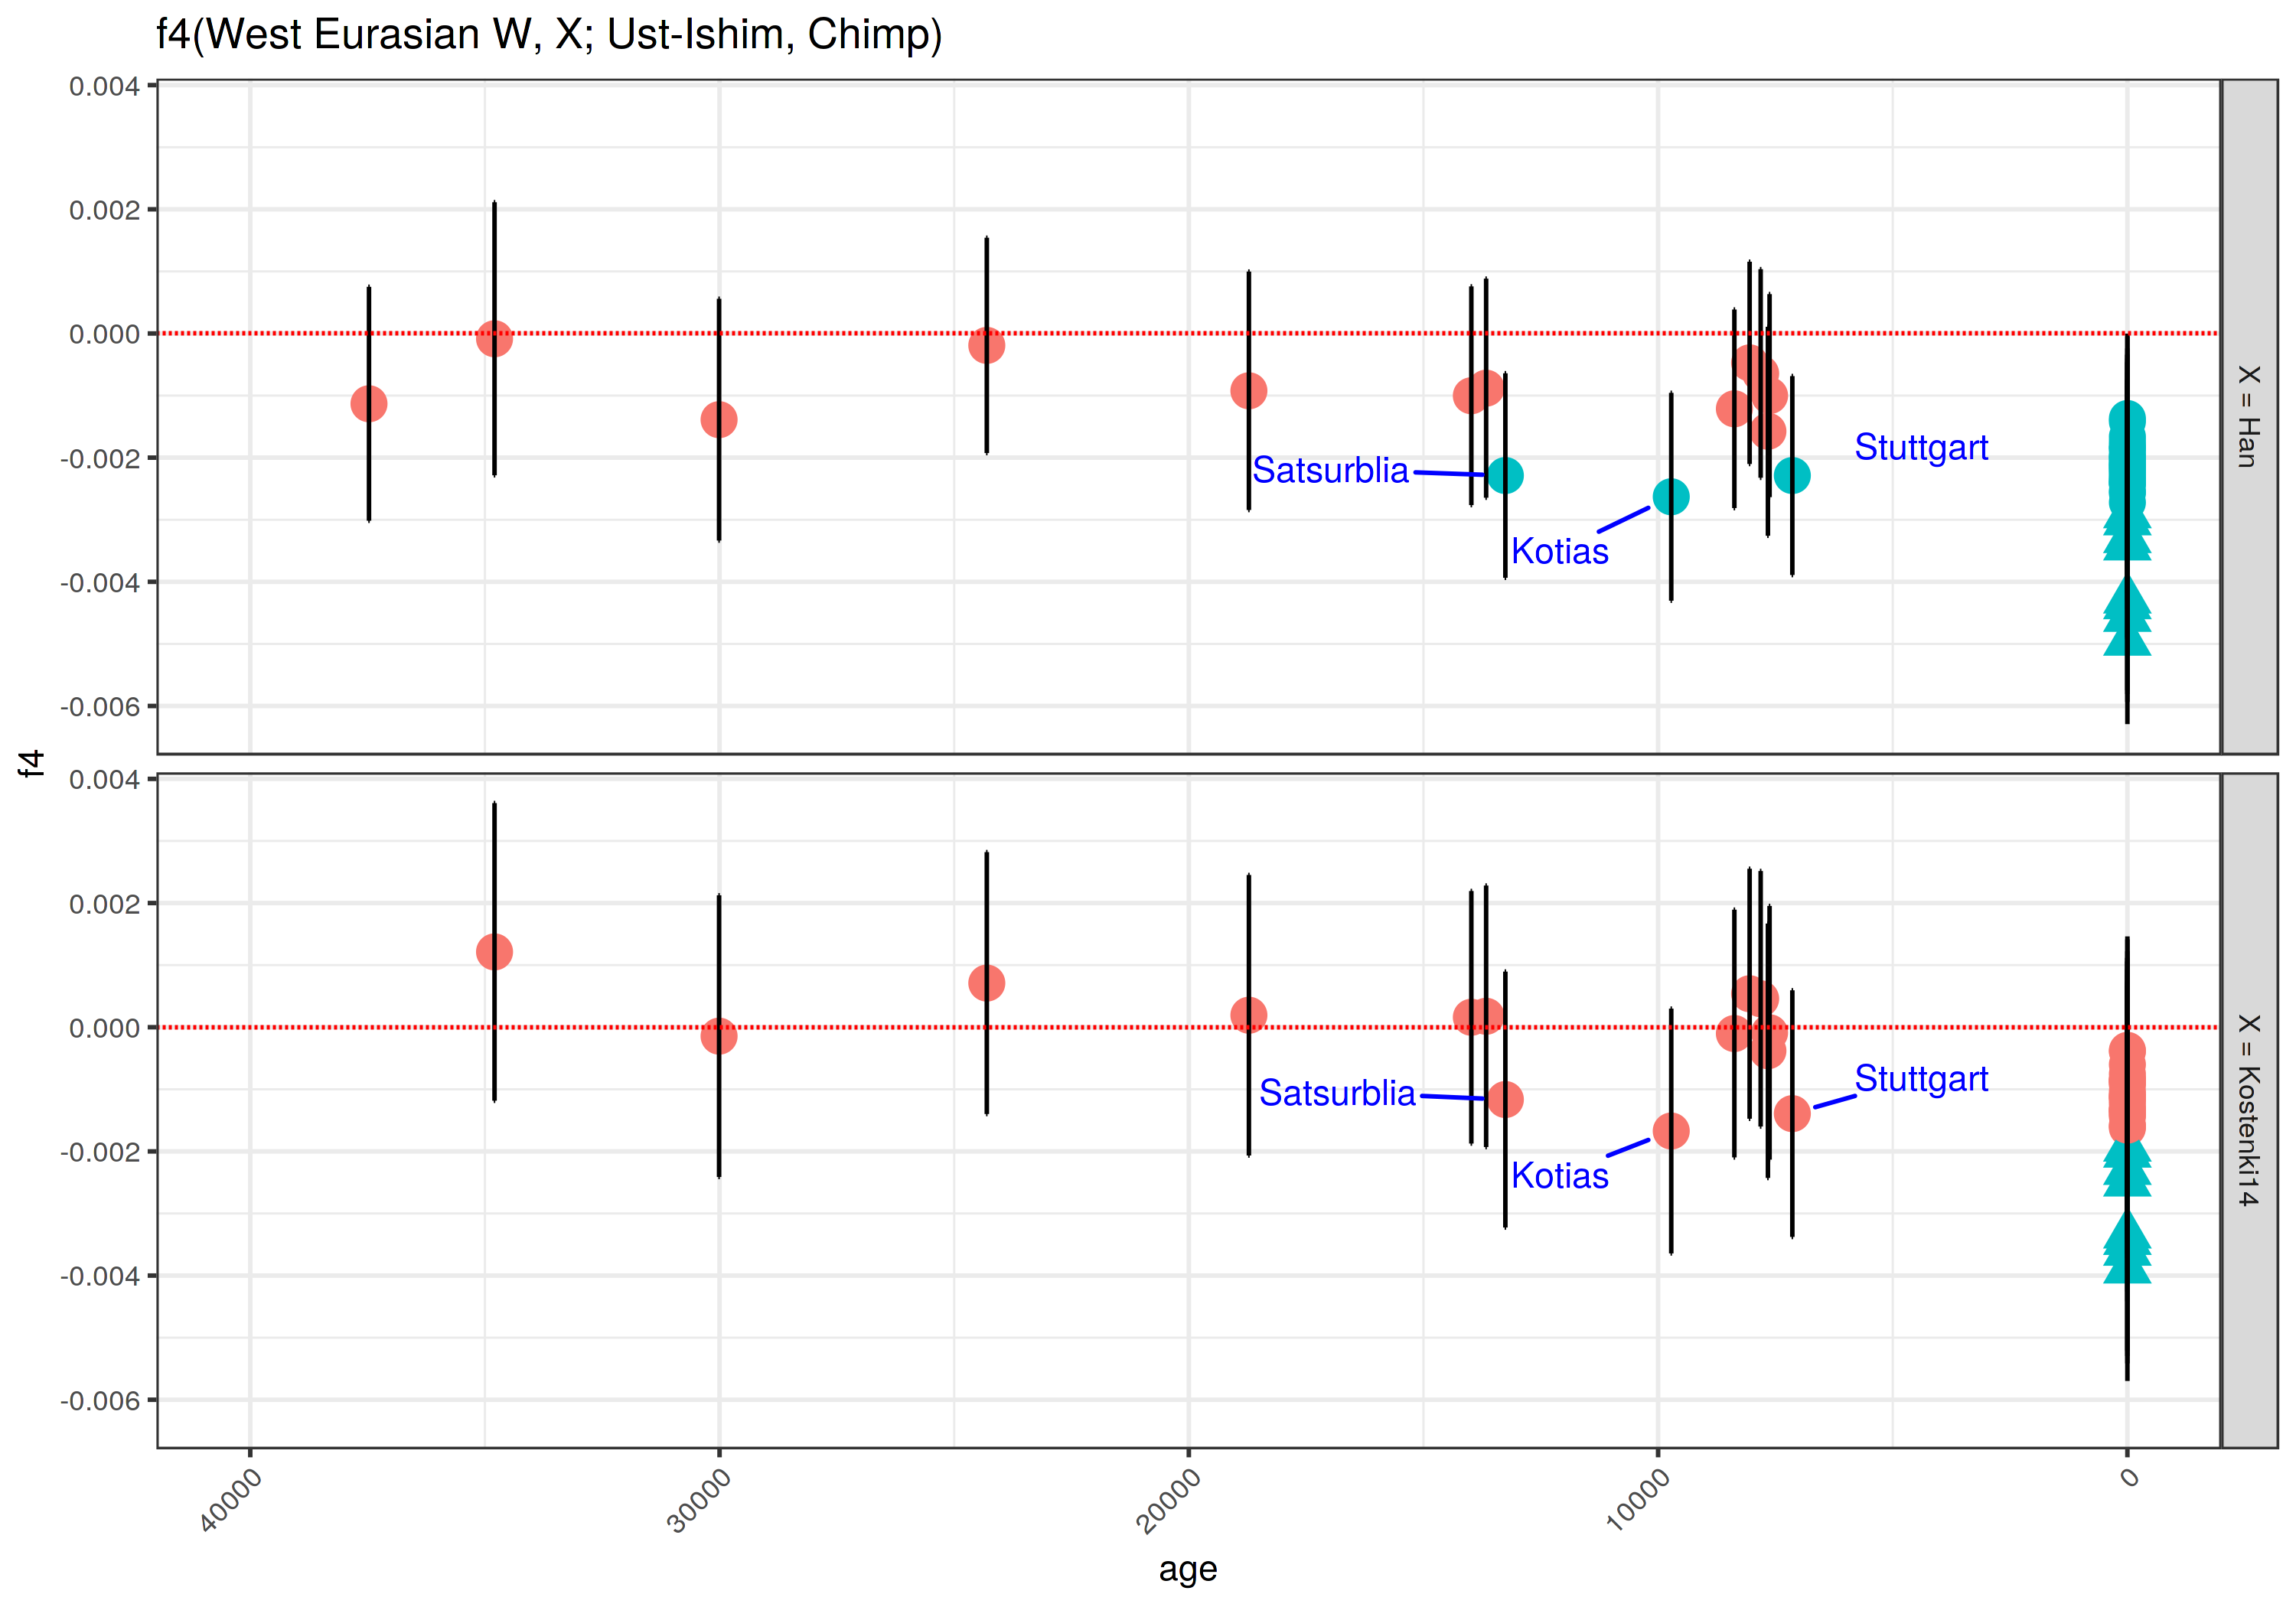

In [23]:
set_dim(10, 7, 300)

filter(basal_eur, snp_count > 500000) %>%
mutate(lbl = ifelse(W %in% c("Stuttgart", "Satsurblia", "Kotias"), W, ""),
       X = paste("X =", X)) %>% 
  ggplot(aes(age, f4)) +
  geom_point(aes(shape = W %in% near_east, color = abs(Zscore) > 3), size = 5) +
  geom_errorbar(aes(ymin = f4 - 3 * stderr, ymax = f4 + 3 * stderr)) +
  geom_hline(yintercept = 0, linetype = 2, color = "red") +
  geom_text_repel(aes(label = lbl), box.padding = 0.35, point.padding = 1, color = "blue") +
  ggtitle("f4(West Eurasian W, X; Ust-Ishim, Chimp)") +
  theme_bw() + facet_grid(X ~ .) +
  theme(legend.position = "none", axis.text.x = element_text(hjust = 1, angle = 45)) +
  xlim(40000, 0)

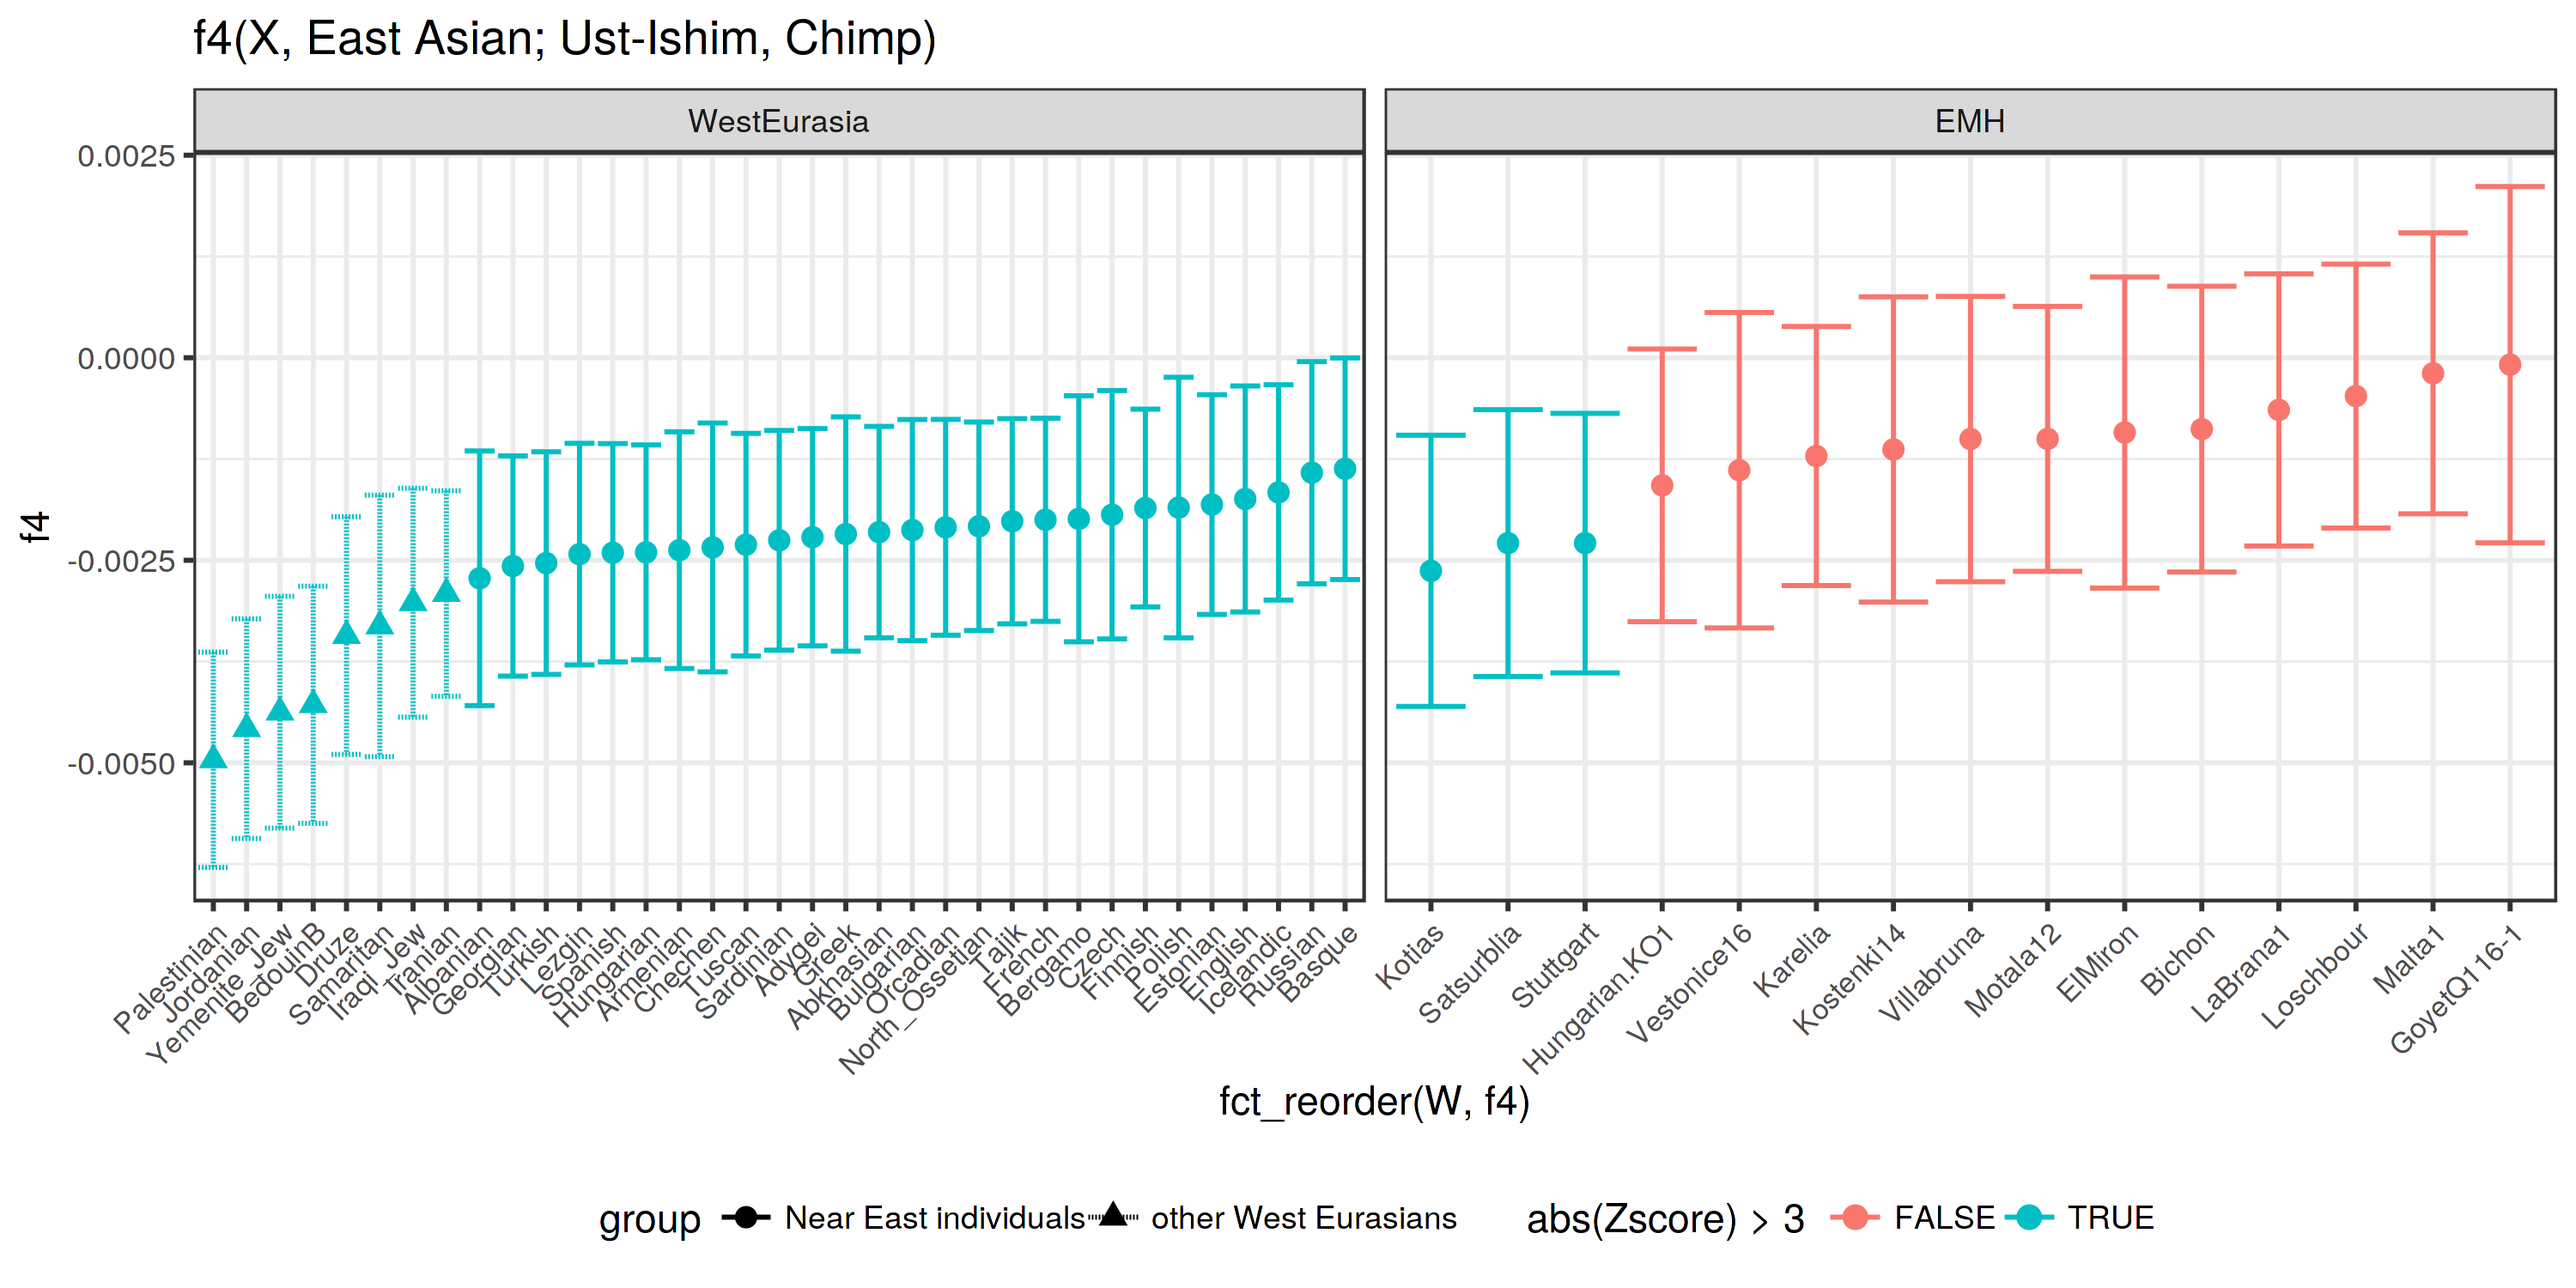

In [24]:
set_dim(10, 5, 300)

filter(basal_eur, X == "Han", snp_count > 500000) %>% 
  mutate(pop = factor(pop, levels = c("WestEurasia", "EMH")),
         group = ifelse(! W %in% near_east, "Near East individuals", "other West Eurasians")) %>% 
  ggplot(aes(fct_reorder(W, f4), f4, shape = group, color = abs(Zscore) > 3)) +
  geom_point(size = 2.5) +
  geom_errorbar(aes(ymin = f4 - 3 * stderr, ymax = f4 + 3 * stderr, linetype = group)) +
  ggtitle("f4(X, East Asian; Ust-Ishim, Chimp)") +
  theme_bw() +
  facet_wrap(~ pop, scales = "free_x") +
  theme(legend.position = "bottom", axis.text.x = element_text(size = 8, hjust = 1, angle = 45))

In [25]:
saveRDS(basal_eur, here("data/rds/array_basal_eur.rds"))

## Whole-genome analysis of basal Eurasian admixture vs Neandertal ancestry

In [26]:
whole_f4 %<-% qpDstat(W=filter(samples, pop == "WestEurasia")$name,
                      X="Han", Y="new_UstIshim", Z="Chimp",
                      prefix=paste0("../data/eigenstrat/whole_genome/whole_genome"), f4mode = TRUE)

In [27]:
whole_nea %<-% qpF4ratio(
    X=c("new_UstIshim", "new_Loschbour", filter(samples, pop %in% c("WestEurasia", "EastAsia"))$name),
    A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp",
    prefix=paste0("../data/eigenstrat/whole_genome/whole_genome")
)

In [28]:
whole_basal <- inner_join(whole_f4, samples, by = c("W" = "name"))

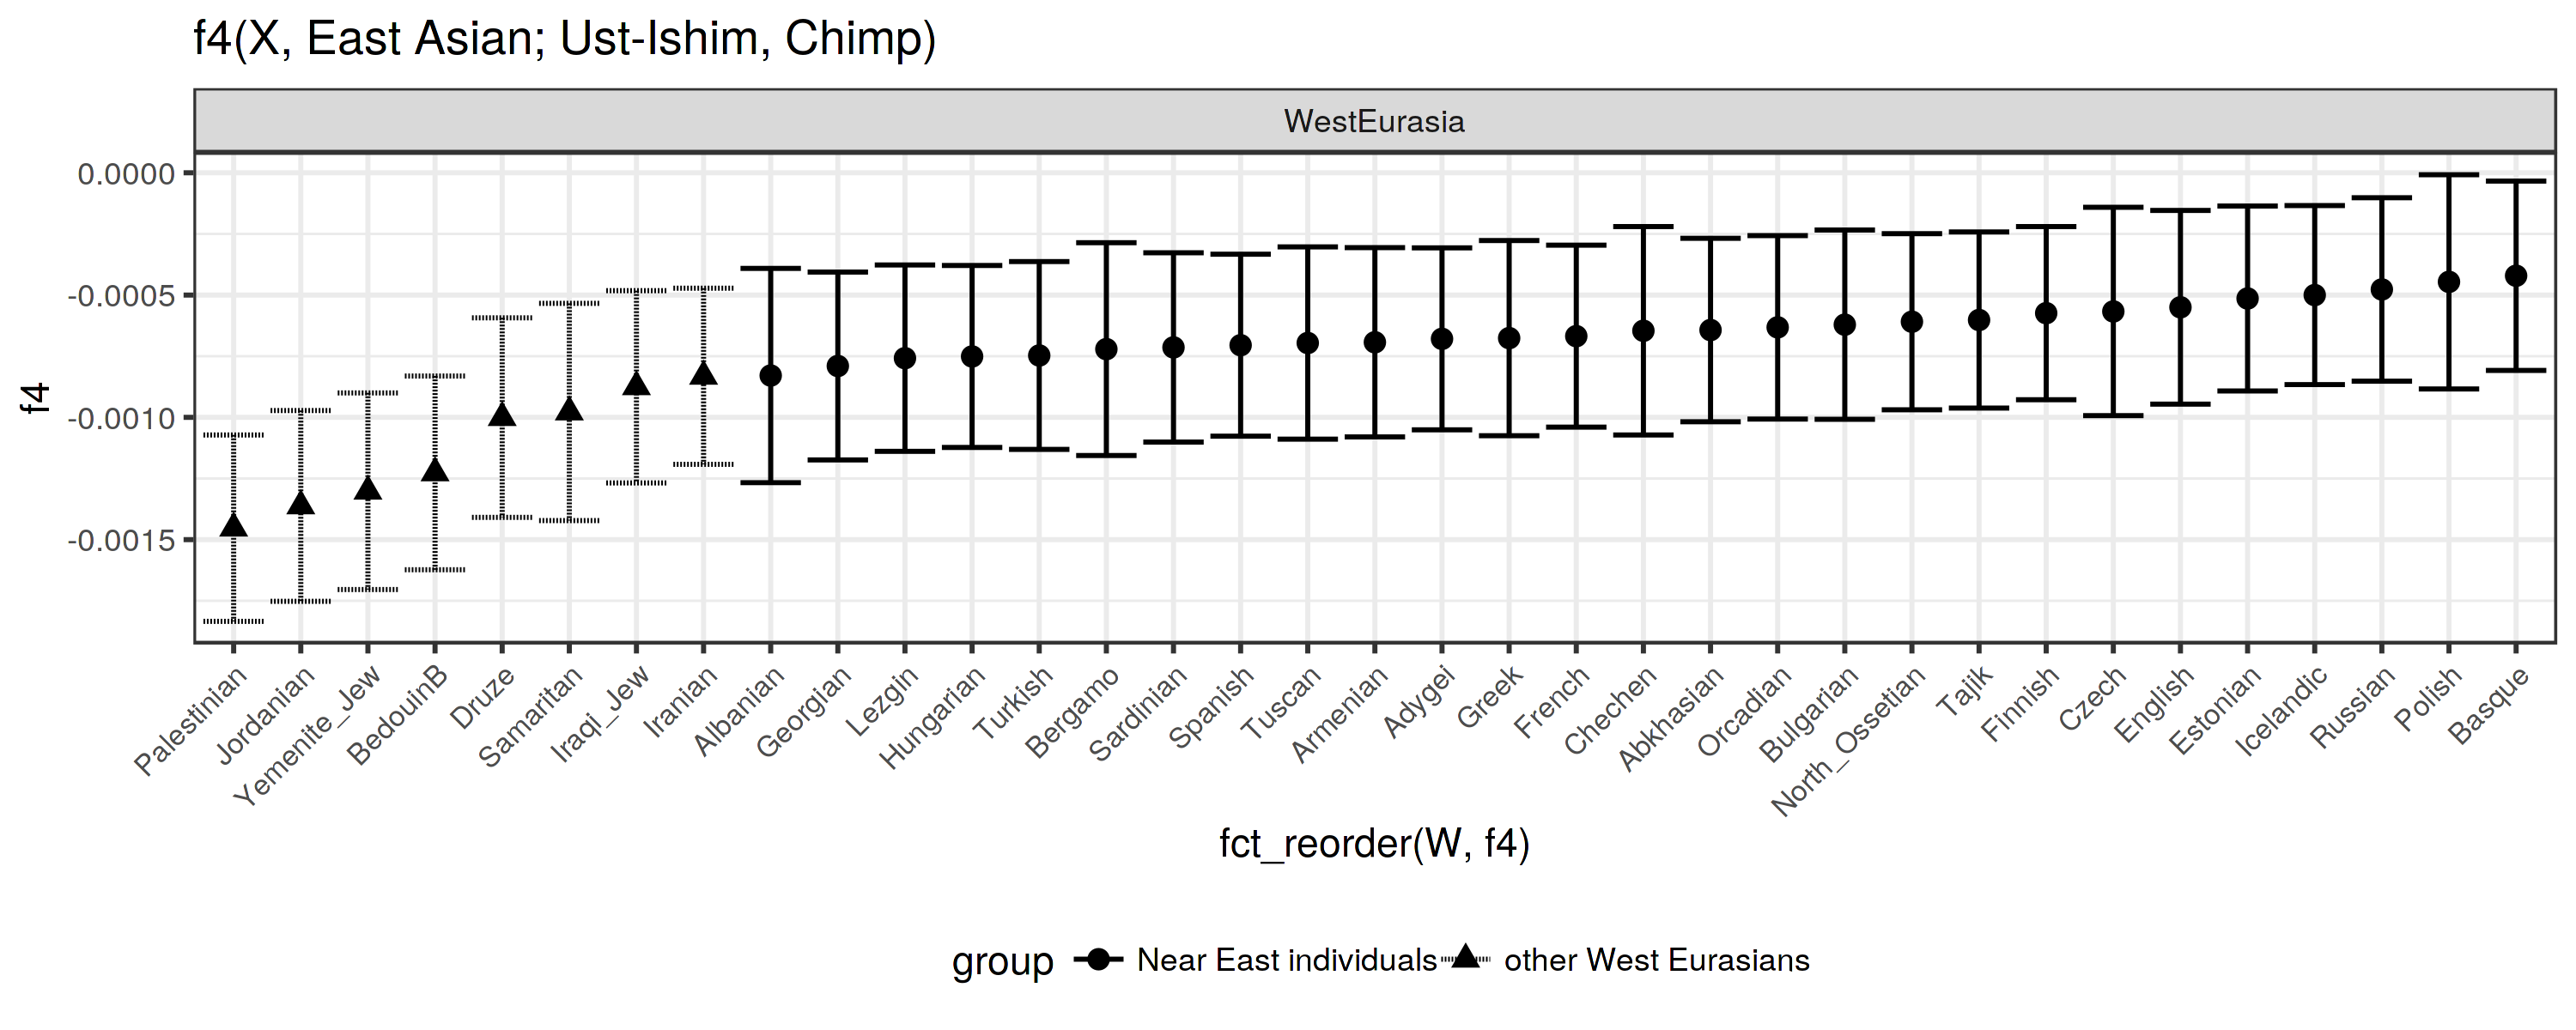

In [29]:
set_dim(10, 4, 300)

filter(whole_basal, X == "Han", pop == "WestEurasia") %>% 
  mutate(pop = factor(pop, levels = c("WestEurasia", "EMH")),
         group = ifelse(! W %in% near_east, "Near East individuals", "other West Eurasians")) %>% 
  ggplot(aes(fct_reorder(W, f4), f4, shape = group)) +
  geom_point(size = 2.5) +
  geom_errorbar(aes(ymin = f4 - 3 * stderr, ymax = f4 + 3 * stderr, linetype = group)) +
  ggtitle("f4(X, East Asian; Ust-Ishim, Chimp)") +
  theme_bw() +
  facet_wrap(~ pop, scales = "free_x") +
  theme(legend.position = "bottom", axis.text.x = element_text(size = 8, hjust = 1, angle = 45))

In [30]:
nea_be <- inner_join(
    select(whole_nea, name = X, alpha),
    select(whole_basal, name = W, pop, f4, age)
) %>%
    mutate(group = case_when(name %in% near_east ~ "Near East individuals",
                             pop == "EMH" ~ "EMH",
                             TRUE ~ "other West Eurasians"),
           name = ifelse(age == 0, name, paste0(name, " (", as.integer(age / 1000), " ky)"))) %>%
    filter(pop == "WestEurasia")

Joining, by = "name"


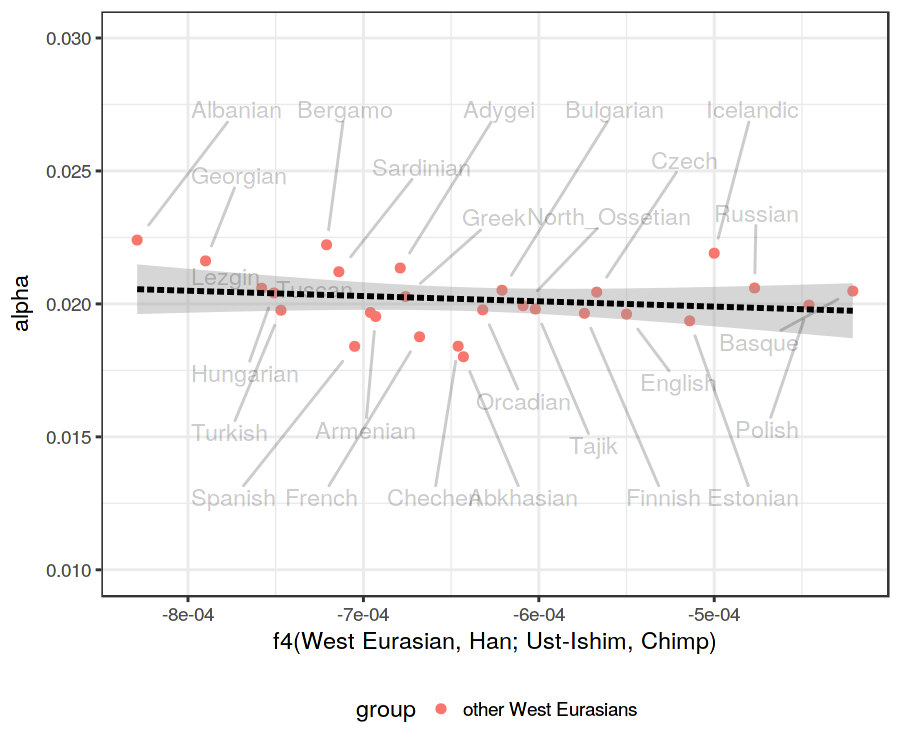

In [31]:
set_dim(6, 5)

filter(nea_be, !name %in% near_east) %>%
ggplot(aes(f4, alpha, color = group)) +
    geom_point() +
    geom_smooth(method = "lm", linetype = 5, color = "black", aes(group = 1)) +
    geom_text_repel(color = "black", aes(label = name), box.padding = 3, point.padding = 1, alpha = 1/5) +
    theme_bw() + theme(legend.position = "bottom") +
    xlab("f4(West Eurasian, Han; Ust-Ishim, Chimp)") + ylim(0.01, 0.03)

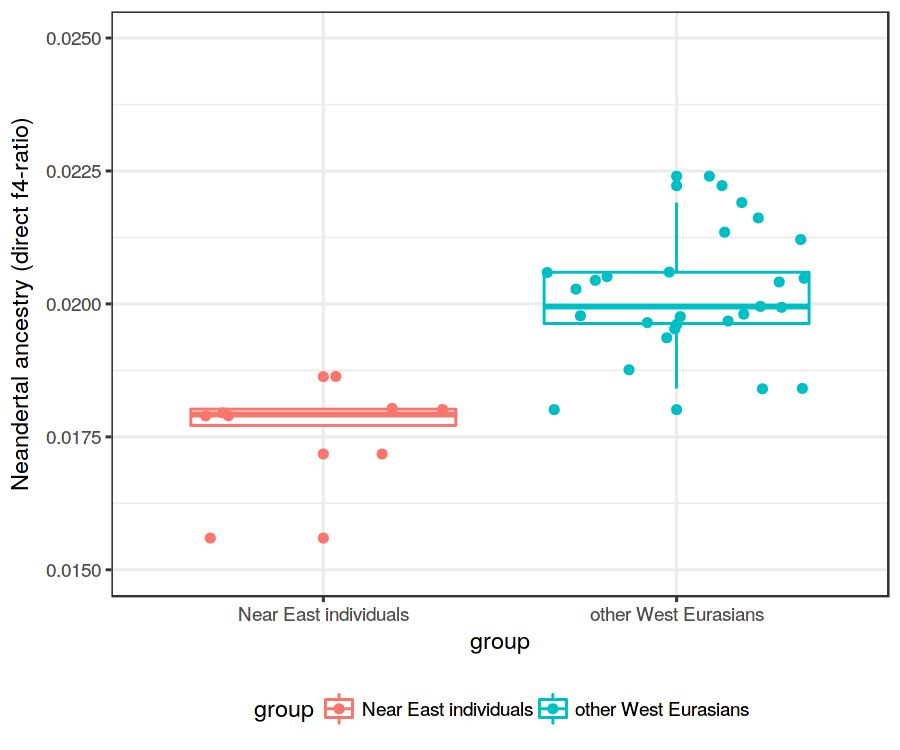

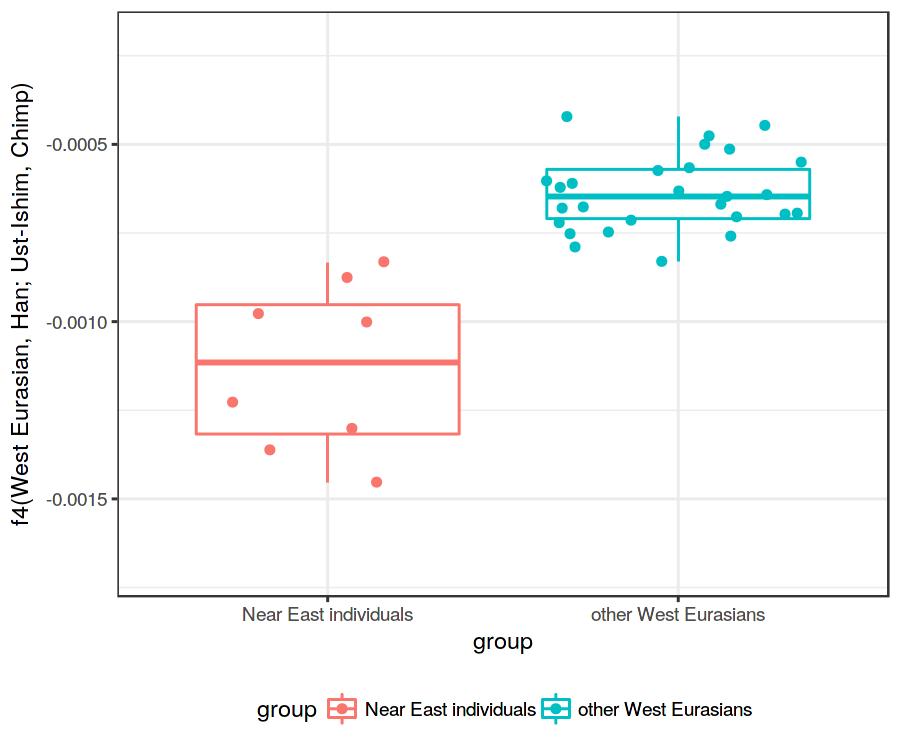

In [32]:
set_dim(6, 5)

ggplot(nea_be, aes(group, alpha, color = group)) +
    geom_boxplot() + geom_jitter() +
    theme_bw() + theme(legend.position = "bottom") +
    ylab("Neandertal ancestry (direct f4-ratio)") +
    ylim(0.015, 0.025)

ggplot(nea_be, aes(group, f4, color = group)) +
    geom_boxplot() + geom_jitter() +
    theme_bw() + theme(legend.position = "bottom") +
    ylab("f4(West Eurasian, Han; Ust-Ishim, Chimp)") +
    ylim(-0.0017, -0.0002)

In [33]:
saveRDS(nea_be, here("data/rds/whole_genome_nea_be.rds"))